In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Lets make a first difffusion model

In [2]:
import torch #The deeplearning library we will be using for this project
import torch.nn as nn #This imports the library to define neural network by ourself
import torch.optim as optim #provide us with multiple optimizer algorithm
from torch.utils.data import DataLoader #to load the data in batch
from torchvision import datasets, transforms #for mnist dataset and transform for data agumentation
import matplotlib.pyplot as plt #for plotting progress plots and sometimes ploting image in the graph

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #using cuda if we have

# MNIST dataset
transform = transforms.ToTensor() #transform the data into tensor
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True) #simply downloads the data
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) #puts the data in dataloader


100%|██████████| 9.91M/9.91M [00:00<00:00, 37.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.04MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.76MB/s]


now lets define encoder and decoder

In [3]:
latent_dim = 2  
# keep it 2D so we can visualize
hidden_dim = 400 
#the layer in betwen input and the latent output

class Encoder(nn.Module): 
    #lets define an nn to encode the input into the mean and variance which describe the region wthin latent space and as you know to define the neural nets we need to inherit the nn.module class
    def __init__(self):  
        #defining a constructor which will define the forward linear layer every time the class is instanciated
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden_dim)
        #and you know that the weight is defined for every input to ouptut connection and bias for every output connection 
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        #so this function basically takes your data and run it throught the layers and return you the output of the  neural network the encoder
        x = torch.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module): #same goes for decoder part
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 28*28)

    def forward(self, z):
        x = torch.relu(self.fc1(z))
        x = torch.sigmoid(self.fc_out(x))  # output in [0,1]
        return x


now lets define the entire model

In [4]:
class VAE(nn.Module):
    #now we define the vae model that takes the input, encodes it to a probability\
    #distribution then sample it using reparemeterization trick and then use that
    #sampled z values to decode into the models output
    def __init__(self):
        super().__init__()
        #we instanciate encoder and decoder the moment we define the model
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        #then we define the reparemetize funtion that takes the encoder output and sample z values
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        #forward prop of the model where it encodes->samples->decodes
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar


Lets define the loss fucntion

In [5]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence between q(z|x) and p(z) which is equal to N(0,1)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD


In [6]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)



In [7]:
epochs = 10
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, 28*28).to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}")


Epoch 1, Loss: 189.4679
Epoch 2, Loss: 167.1036
Epoch 3, Loss: 163.1914
Epoch 4, Loss: 160.9739
Epoch 5, Loss: 159.2191
Epoch 6, Loss: 157.6935
Epoch 7, Loss: 156.4154
Epoch 8, Loss: 155.4301
Epoch 9, Loss: 154.5674
Epoch 10, Loss: 153.7745


latent space visualization

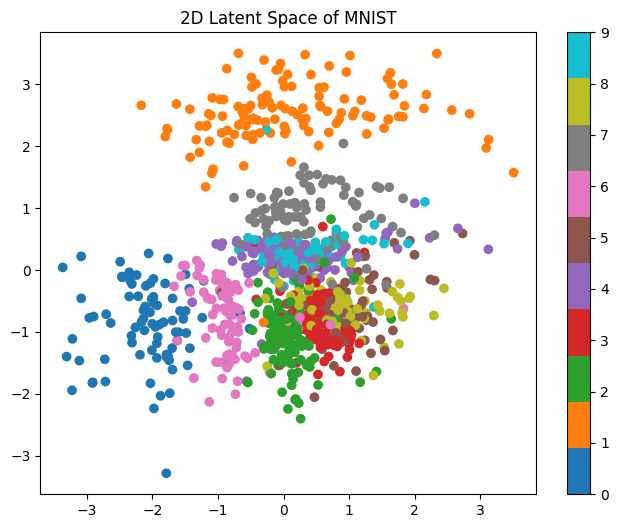

In [8]:
# plotting the encoder outputted mean of the mnist data into the latent space
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

vae.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.view(-1, 28*28).to(device)
        mu, logvar = vae.encoder(x)
        z = mu.cpu().numpy()
        plt.figure(figsize=(8,6))
        plt.scatter(z[:,0], z[:,1], c=y, cmap='tab10')
        plt.colorbar()
        plt.title("2D Latent Space of MNIST")
        plt.show()
        break


output generation from the random latent space

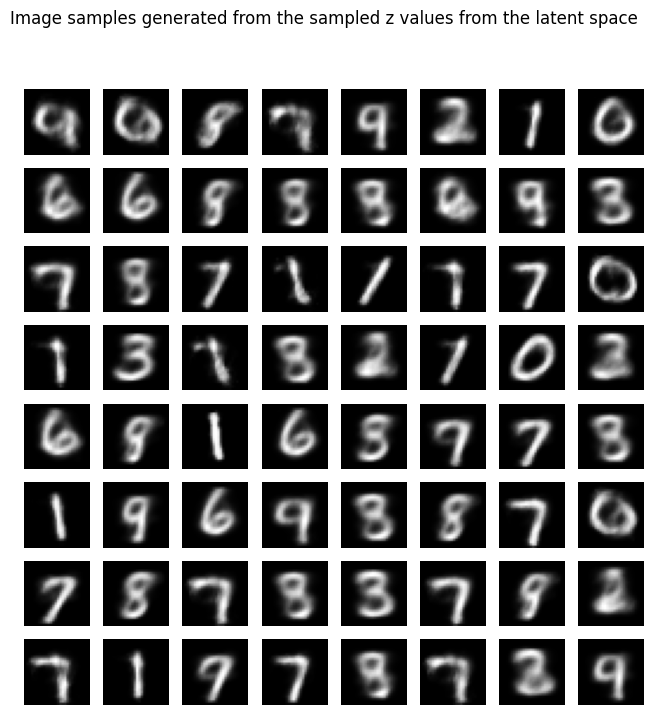

In [9]:
# Now we randomly sample from latent space & decode
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)  #collecting 64 random samples
    samples = vae.decoder(z).cpu().view(64,1,28,28) #64 batches of gray scale(single chanel), 28 by 28 images

grid = torch.cat([s for s in samples], dim=0)
plt.figure(figsize=(8,8))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(samples[i][0], cmap="gray")
    plt.axis("off")
plt.suptitle("Image samples generated from the sampled z values from the latent space")
plt.show()


****What amazed you more decoder ability to generate or latent space ability to store meaning?****